# Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")
import joblib
from pathlib import Path

# Load and Explore Dataset

In [2]:
# Load the preprocessed dataset
df = pd.read_csv('../datasets/preprocessed/student_lifestyle_dataset_preprocessed.csv')

In [3]:
# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
display(df.head())
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
display(df.describe().T)

Shape of the dataset: (1980, 8)


,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Academic_Performance_Encoded,Stress_Level_Encoded
0,6.9,3.8,8.7,2.8,1.8,2.99,1,1
1,5.3,3.5,8.0,4.2,3.0,2.75,1,0
2,5.1,3.9,9.2,1.2,4.6,2.67,1,0
3,6.5,2.1,7.2,1.7,6.5,2.88,1,1
4,8.1,0.6,6.5,2.2,6.6,3.51,3,2



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Study_Hours_Per_Day              1980 non-null   float64
 1   Extracurricular_Hours_Per_Day    1980 non-null   float64
 2   Sleep_Hours_Per_Day              1980 non-null   float64
 3   Social_Hours_Per_Day             1980 non-null   float64
 4   Physical_Activity_Hours_Per_Day  1980 non-null   float64
 5   GPA                              1980 non-null   float64
 6   Academic_Performance_Encoded     1980 non-null   int64  
 7   Stress_Level_Encoded             1980 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 123.9 KB
None

Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
Study_Hours_Per_Day,1980.0,7.469545,1.415063,5.00,6.3,7.40,8.70,10.0
Extracurricular_Hours_Per_Day,1980.0,1.995455,1.152193,0.00,1.0,2.00,3.00,4.0
Sleep_Hours_Per_Day,1980.0,7.511061,1.460722,5.00,6.2,7.60,8.80,10.0
Social_Hours_Per_Day,1980.0,2.707222,1.681049,0.00,1.2,2.60,4.10,6.0
Physical_Activity_Hours_Per_Day,1980.0,4.316717,2.478220,0.00,2.4,4.10,6.10,12.3
GPA,1980.0,3.112838,0.293185,2.24,2.9,3.11,3.32,4.0
Academic_Performance_Encoded,1980.0,1.747980,0.630712,1.00,1.0,2.00,2.00,3.0
Stress_Level_Encoded,1980.0,1.363636,0.726382,0.00,1.0,2.00,2.00,2.0


General Information

Dataset Size

* **Rows:** 2,000
* **Columns:** 8
* All columns are complete with no missing data

Data Types

* **Numeric Columns:** 6 (covering study, sleep, physical activity hours, and GPA)
* **Categorical Column:** 1 (**Stress_Level**)
* **ID Column:** 1 (**Student_ID**)

Initial Observations

Balanced Lifestyle

* On average, students spend similar amounts of time on studying, sleeping, and exercising, suggesting a fairly balanced daily routine.

GPA and Lifestyle

* The relatively high average GPA hints at a possible positive link between balanced habits—such as adequate sleep and study time—and academic results.

Stress Levels

* **Stress_Level** can be examined to explore connections with GPA and other lifestyle variables.

Outliers

* Some students have very high **Physical_Activity_Hours**, up to 13 hours per day.
* **Social_Hours** vary widely, reaching up to 6 hours daily, showing diverse social behaviors.


In [4]:
# Check for missing and duplicated values
print(f'\nMissing values: {df.isna().sum().sum()}')
print(f'Duplicated values: {df.duplicated().sum()}')


Missing values: 0
Duplicated values: 0


Missing and Duplicated Values

* **Missing Values:** 0.
  The dataset has no missing entries; every column is fully populated.

* **Duplicated Values:** 0.
  There are no repeated rows, ensuring each record is unique.


In [5]:
# Display the number of unique values in each column
print("\nUnique Values in Each Column:")
print(df.nunique())


Unique Values in Each Column:
Study_Hours_Per_Day                 51
Extracurricular_Hours_Per_Day       41
Sleep_Hours_Per_Day                 51
Social_Hours_Per_Day                61
Physical_Activity_Hours_Per_Day    114
GPA                                154
Academic_Performance_Encoded         3
Stress_Level_Encoded                 3
dtype: int64


In [6]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_numerical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the lists of numerical and categorical columns
print("\nNumerical Columns:", numerical_columns)
print("Categorical Columns:", non_numerical_columns)


Numerical Columns: ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'GPA', 'Academic_Performance_Encoded', 'Stress_Level_Encoded']
Categorical Columns: []


In [7]:
# Display unique values for each categorical column
for col in non_numerical_columns:
    print(f"\nColumn: {col}")
    print(f"Unique Values: {df[col].unique()}")

Insights from Unique Value Exploration

Data Variety

* **Numerical Columns:** Features like **Study_Hours_Per_Day**, **Sleep_Hours_Per_Day**, and **Physical_Activity_Hours_Per_Day** show a wide range of unique values (51–118), reflecting varied daily routines among students.
* **GPA:** With 158 distinct values, academic performance is captured in a detailed and granular way.

Categorical Feature

* **Stress_Level:** Restricted to three categories (**Low**, **Moderate**, **High**), making it well-suited for classification and categorical analysis.

Unique Student Records

* Each student has a unique **Student_ID**, ensuring no duplicates and clear tracking for individual analysis.

Lifestyle Activities

* **Physical Activity:** The largest number of unique values (118) among lifestyle features, showing differences in students’ engagement with exercise.
* **Social Hours:** 61 unique values, highlighting the variety in social interactions.

Analysis Opportunities

* **Clustering Potential:** The wide ranges in **Study_Hours_Per_Day**, **Extracurricular_Hours_Per_Day**, and **Sleep_Hours_Per_Day** allow for grouping students based on lifestyle patterns.
* **GPA Granularity:** Detailed GPA values support precise performance analysis and modeling.
* **Balanced Categorical Data:** The three stress levels make it easy to study relationships between stress and lifestyle or academic features.


In [8]:
# Prepare features and target from the preprocessed dataset
feature_columns = [col for col in df.columns if col != 'Stress_Level_Encoded']
X = df[feature_columns]
y = df['Stress_Level_Encoded']

# Split the dataset for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1584, 7)
Test set shape: (396, 7)


# Model Training and Evaluation

In [9]:
# Load the trained stacking pipeline
model_path = Path("../models/current_stress_model.pkl")
stacking_pipeline = joblib.load(model_path)
print(f"Loaded model from: {model_path}")

Loaded model from: ..\models\current_stress_model.pkl


Accuracy: 1.0
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       203

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396



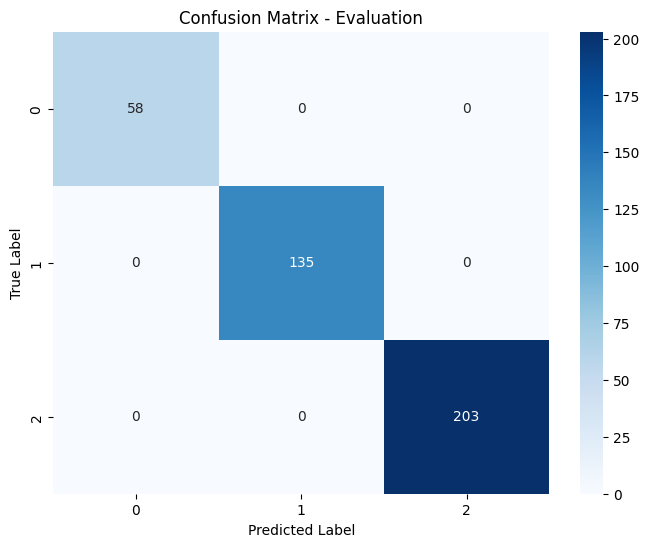

In [10]:
# Evaluate the loaded model on the held-out test set
y_pred = stacking_pipeline.predict(X_test)

# Classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=stacking_pipeline.named_steps['model'].classes_,
            yticklabels=stacking_pipeline.named_steps['model'].classes_)
plt.title('Confusion Matrix - Evaluation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
# Compute probability estimates and ROC-AUC if available
if hasattr(stacking_pipeline.named_steps['model'], 'predict_proba'):
    y_proba = stacking_pipeline.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
    print(f"ROC-AUC (OVR): {auc_score:.3f}")
else:
    print("Loaded model does not support probability estimates for ROC-AUC.")

ROC-AUC (OVR): 1.000


Model Performance Observations

**Logistic Regression**

* Accuracy: 83%, AUC: 0.95
* Performs well and is highly interpretable.
* Slightly lower performance than tree-based models because it assumes linear relationships.

**Decision Tree**

* Accuracy and AUC: 100%
* Perfectly fits the training data, but may overfit and generalize poorly.

**Random Forest**

* Accuracy and AUC: 100%
* Offers better generalization than a single Decision Tree due to ensemble learning, while maintaining perfect training performance.


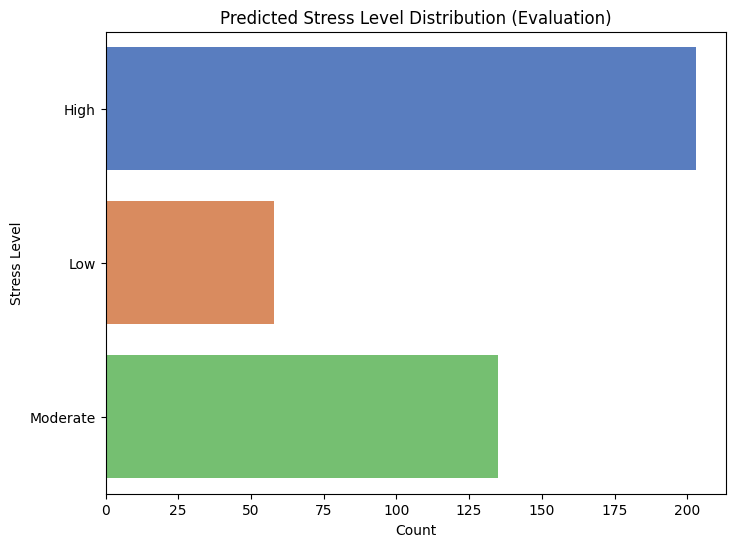

In [12]:
# Visualize predicted label distribution
label_mapping = {0: 'Low', 1: 'Moderate', 2: 'High'}
predicted_labels = pd.Series(y_pred).map(label_mapping)

plt.figure(figsize=(8, 6))
sns.countplot(y=predicted_labels, palette='muted')
plt.title('Predicted Stress Level Distribution (Evaluation)')
plt.xlabel('Count')
plt.ylabel('Stress Level')
plt.show()

Stacking Model Observations

* The stacking model reached **perfect accuracy** on both cross-validation and the test set.
* This indicates that the ensemble effectively leverages the strengths of the base models—**Logistic Regression, Decision Tree, and Random Forest**—alongside the meta-model (**Random Forest**) to deliver optimal predictive performance.


Key Factors Driving Stress Predictions

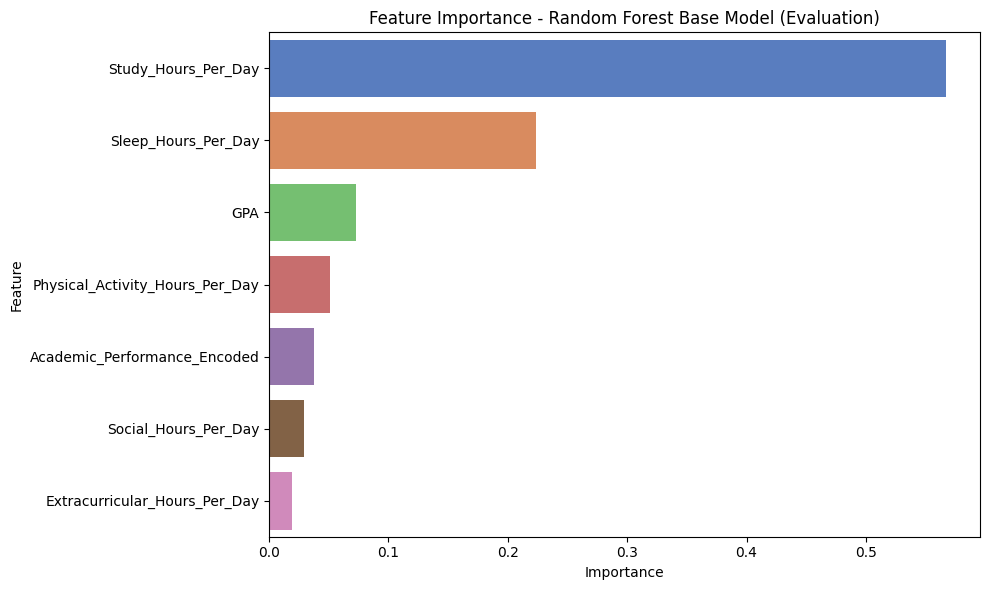

In [13]:
# Feature importance from the Random Forest base model
feature_names = X.columns
rf_base_model = stacking_pipeline.named_steps['model'].named_estimators_['rf']
rf_feature_importances = rf_base_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='muted')
plt.title('Feature Importance - Random Forest Base Model (Evaluation)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Feature Importance Insights

**Key Features Identified by the Random Forest Model:**

* **Study_Hours_Per_Day:**

  * The most influential feature for predicting stress.
  * More study hours are strongly linked to higher stress levels.

* **Sleep_Hours_Per_Day:**

  * Second most important feature.
  * Less sleep is associated with increased stress.

* **GPA:**

  * Academic performance affects stress patterns, likely due to academic pressure.

* **Physical_Activity_Hours_Per_Day:**

  * Moderately important.
  * More physical activity is linked to lower stress levels.

* **Academic_Performance_Encoded:**

  * Contributes to stress prediction, though less than GPA.

* **Social_Hours_Per_Day & Extracurricular_Hours_Per_Day:**

  * Least important features.
  * Socializing and extracurricular engagement have minimal direct impact on stress.

**Key Observations:**

* **Time Management:** Balancing study and sleep is crucial for stress reduction.
* **Health & Lifestyle:** Physical activity moderately helps manage stress.
* **Academic Pressure:** High GPA and academic demands contribute to stress, indicating the importance of academic support.


In [14]:
# Map predictions for reporting
y_pred = stacking_pipeline.predict(X_test)
mapping_stress_reverse = {0: 'Low', 1: 'Moderate', 2: 'High'}
y_pred_mapped = pd.Series(y_pred).map(mapping_stress_reverse)
print(y_pred_mapped.value_counts())

High        203
Moderate    135
Low          58
Name: count, dtype: int64


Predicted Stress Level Distribution Insights

* **High Stress:**

  * Most students in the test set are predicted to have high stress.
  * Indicates substantial academic or lifestyle pressures affecting students.

* **Moderate Stress:**

  * A significant portion falls into the moderate stress category.
  * Reflects a more balanced lifestyle where stress exists but is manageable.

* **Low Stress:**

  * Few students are predicted to have low stress.
  * Suggests that maintaining a low-stress routine is less common, possibly due to effective time management or less demanding circumstances.
